In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
requests=pd.read_csv("data.csv",sep=",",header=0)
#requests.index=requests['hotel_id']
requests=requests.drop(['hotel_id'],axis=1)
requests=requests.drop(['avatar_name'],axis=1)
requests.head()

,group,brand,city,parking,pool,children_policy,price,stock,date,language,mobile
0,Morriott International,Corlton,amsterdam,1,1,0,366,14,10,austrian,0
1,Accar Hotels,Safitel,amsterdam,1,0,0,359,10,10,austrian,0
2,Yin Yang,Ardisson,amsterdam,1,1,0,193,10,10,austrian,0
3,Boss Western,Boss Western,amsterdam,0,0,0,205,4,10,austrian,0
4,Accar Hotels,Ibas,amsterdam,1,0,0,86,0,10,austrian,0


In [3]:
#on transforme les variables en facteur
requests=pd.get_dummies(requests, columns=['group','city','brand','language'])

In [4]:
price=requests["price"]
X_train,X_test,price_train,price_test=train_test_split(requests,price,test_size=0.25,random_state=11)
X_train=X_train.drop(['price'], axis=1)
X_test=X_test.drop(['price'], axis=1)

In [5]:
X_train.head()
#X_test.head()

,parking,pool,children_policy,stock,date,mobile,group_Accar Hotels,group_Boss Western,group_Chillton Worldwide,group_Independant,...,language_italian,language_lithuanian,language_luxembourgish,language_maltese,language_polish,language_portuguese,language_romanian,language_slovakian,language_spanish,language_swedish
83402,1,0,0,38,25,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
270260,1,0,0,0,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
181784,1,0,0,12,25,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
157289,0,0,0,10,10,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
244836,1,0,0,4,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train.shape

(227049, 62)

In [7]:
rf= RandomForestRegressor(n_estimators=80,max_features=9)
rfFit=rf.fit(X_train, price_train)
# Importance décroissante des variables
feature_importance_df = pd.DataFrame({
    'Feature' : X_train.columns,
    'Importance' : rfFit.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
35,brand_Safitel,0.130854
1,pool,0.106060
3,stock,0.084184
25,brand_Corlton,0.079468
28,brand_Independant,0.068213
...,...,...
51,language_irish,0.000166
56,language_polish,0.000165
52,language_italian,0.000164
48,language_german,0.000163


In [8]:
param=[{"n_estimators":list(range(10,50,10)),"max_features":list(range(2,10,1)) }]
n_features = np.shape(X_train)[1]
rf= GridSearchCV(RandomForestRegressor(),
        param,cv=10,n_jobs=-1)
rfOpt=rf.fit(X_train, price_train)

# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.028963, Meilleur paramètre = {'max_features': 9, 'n_estimators': 40}


In [9]:
#max features = 9 qd la liste va jusqu'à 10  et n estimators = 80

In [ ]:
rf= RandomForestRegressor(n_estimators = 90, max_features = 9)
rfOpt=rf.fit(X_train, price_train)

# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

<AxesSubplot:title={'center':'Feature Importance'}, xlabel='Importance', ylabel='Feature'>

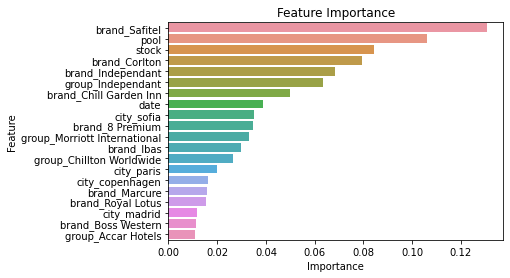

In [10]:
plt.title('Feature Importance')
sns.barplot(data = feature_importance_df.head(20), x='Importance', y='Feature')

In [ ]:
#Calcul de la valeur absolue des erreurs
predictions = rf.predict(X_test)
print("MSE=",mean_squared_error(predictions,price_test))
print("R2=",r2_score(price_test,predictions))

MSE= 203.8512593797848
R2= 0.9723225862116773


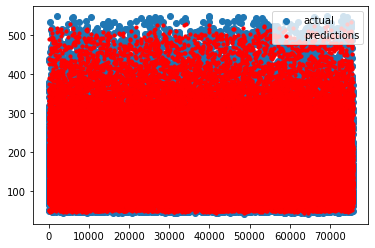

In [ ]:
x = np.linspace(1,np.shape(price_test)[0],np.shape(price_test)[0])
plt.scatter(x,price_test,label='actual')
plt.scatter(x,predictions,s=10,c='red',label='predictions')
plt.legend()

# Ice Plot

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import PartialDependenceDisplay

In [26]:
from pdpbox import pdp, get_dataset, info_plots
model = rf #lr, mlp
model_name = 'random forest'

features_importance_dict = {}
features_importance_dict[model_name] = feature_importance_df #add the dataframe to your dictionnary

top_5_features = features_importance_dict[model_name].Feature[:5].values

for i, feature in enumerate(top_5_features, 1):
  #print(feature)
  pdp_feat = pdp.pdp_isolate(model=model, dataset=X_test, model_features=features_importance_dict[model_name].Feature.values, feature=feature)
  pdp.pdp_plot(pdp_feat, feature, plot_lines=True, frac_to_plot=0.5)
#plt.show()

ModuleNotFoundError: No module named 'pdpbox'

In [ ]:
features_to_plot = ['pool', 'brand']
inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=features_importance_dict[model_name].Feature, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

## Prédictions sur le test set

In [12]:
test_set = pd.read_csv('test_set.csv')
test = test_set.drop(['order_requests'],axis=1)
bis = test

test = test.drop(['index'],axis=1)
test.head()
features = pd.read_csv("features/features_hotels.csv",sep=",",header=0)
features_test = features.loc[features["hotel_id"].loc[test['hotel_id']]]
features_test = features_test.reset_index()
df = pd.concat([features_test,test[['stock','date','language',"mobile"]]],axis=1)
df = df.drop(['hotel_id'],axis=1)
df = df.drop(['index'],axis=1)
df

,group,brand,city,parking,pool,children_policy,stock,date,language,mobile
0,Boss Western,J.Halliday Inn,vilnius,1,0,0,46,21,romanian,0
1,Accar Hotels,Marcure,vilnius,1,1,0,32,21,romanian,0
2,Independant,Independant,vilnius,1,0,0,12,21,romanian,0
3,Accar Hotels,Ibas,vilnius,0,0,0,10,21,romanian,0
4,Accar Hotels,Safitel,vilnius,1,1,1,42,21,romanian,0
...,...,...,...,...,...,...,...,...,...,...
6639,Accar Hotels,Ibas,rome,1,0,0,1,5,irish,0
6640,Accar Hotels,Marcure,vienna,1,0,0,1,1,irish,1
6641,Boss Western,Boss Western,vienna,1,0,0,0,1,irish,1
6642,Yin Yang,Ardisson,vienna,1,0,0,0,1,irish,1


In [14]:
df = pd.get_dummies(df, columns = ['group', 'city', 'brand', 'language'])
df.head()

,parking,pool,children_policy,stock,date,mobile,group_Accar Hotels,group_Boss Western,group_Chillton Worldwide,group_Independant,...,language_lithuanian,language_luxembourgish,language_maltese,language_polish,language_portuguese,language_romanian,language_slovakian,language_slovene,language_spanish,language_swedish
0,1,0,0,46,21,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,1,0,32,21,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,12,21,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,10,21,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,1,1,42,21,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [16]:
df = df.drop(columns = ['language_slovene', 'language_latvian' ])

In [20]:
predictions = rfOpt.predict(df)

In [21]:
submission = pd.DataFrame()
submission['index'] = bis['index']
submission['price'] = predictions
submission = submission.reset_index()
submission = submission.drop(['level_0'],axis=1)

In [22]:
submission.to_csv('submission3.csv', index = False)

In [11]:
test=pd.read_csv("test_set.csv",sep=",",header=0)
#test.index=test['hotel_id']
#test=test.drop(['hotel_id'],axis=1)
test=test.drop(['order_requests'],axis=1)
bis=test

test=test.drop(['index'],axis=1)
test.head()

,city,date,language,mobile,avatar_id,hotel_id,stock
0,vilnius,21,romanian,0,1,161,46
1,vilnius,21,romanian,0,1,187,32
2,vilnius,21,romanian,0,1,279,12
3,vilnius,21,romanian,0,1,395,10
4,vilnius,21,romanian,0,1,488,42


In [ ]:
features=pd.read_csv("features_hotels.csv",sep=",",header=0)
features_test=features.loc[features["hotel_id"].loc[test['hotel_id']]]
features_test=features_test.reset_index()

In [ ]:
features.head()

,hotel_id,group,brand,city,parking,pool,children_policy
0,0,Yin Yang,Royal Lotus,paris,1,0,1
1,1,Independant,Independant,copenhagen,1,0,0
2,2,Independant,Independant,madrid,0,0,0
3,3,Independant,Independant,rome,1,0,0
4,4,Independant,Independant,sofia,1,0,0


In [ ]:
df=pd.concat([features_test,test[['stock','date','language',"mobile"]]],axis=1)
df.index=df['hotel_id']
df=df.drop(['hotel_id'],axis=1)
df=df.drop(['index'],axis=1)
df.head()

,group,brand,city,parking,pool,children_policy,stock,date,language,mobile
hotel_id,,,,,,,,,,
161,Boss Western,J.Halliday Inn,vilnius,1,0,0,46,21,romanian,0
187,Accar Hotels,Marcure,vilnius,1,1,0,32,21,romanian,0
279,Independant,Independant,vilnius,1,0,0,12,21,romanian,0
395,Accar Hotels,Ibas,vilnius,0,0,0,10,21,romanian,0
488,Accar Hotels,Safitel,vilnius,1,1,1,42,21,romanian,0


In [ ]:
requests=df

In [ ]:
#on transforme les catégories de string en catégories de nombres (on pourra faire les correspondances plus tard)
_, opt = np.unique(np.array(requests['group']), return_inverse=True)
requests['group']=opt
_, opt = np.unique(np.array(requests['brand']), return_inverse=True)
requests['brand']=opt
_, opt = np.unique(np.array(requests['city']), return_inverse=True)
requests['city']=opt
_, opt = np.unique(np.array(requests['language']), return_inverse=True)
requests['language']=opt
requests

,group,brand,city,parking,pool,children_policy,stock,date,language,mobile
hotel_id,,,,,,,,,,
161,1,8,8,1,0,0,46,21,22,0
187,0,9,8,1,1,0,32,21,22,0
279,3,7,8,1,0,0,12,21,22,0
395,0,6,8,0,0,0,10,21,22,0
488,0,14,8,1,1,1,42,21,22,0
...,...,...,...,...,...,...,...,...,...,...
987,0,6,4,1,0,0,1,5,14,0
26,0,9,7,1,0,0,1,1,14,1
263,1,2,7,1,0,0,0,1,14,1


In [ ]:
predictions = rf.predict(df)

In [ ]:
submission=pd.DataFrame()
submission['index']=bis['index']
submission['price']=predictions
submission=submission.reset_index()
submission=submission.drop(['level_0'],axis=1)

In [ ]:
submission.head()

,index,price
0,0,141.014256
1,1,193.967500
2,2,95.096000
3,3,77.178125
4,4,248.062500


In [ ]:
submission.to_csv('submission.csv', index = False)

In [ ]:
test_set = pd.read_csv('test_set.csv')
test = test_set.drop(['order_requests'],axis=1)
bis = test

test = test.drop(['index'],axis=1)
test.head()
features = pd.read_csv("features/features_hotels.csv",sep=",",header=0)
features_test = features.loc[features["hotel_id"].loc[test['hotel_id']]]
features_test = features_test.reset_index()
df = pd.concat([features_test,test[['stock','date','language',"mobile"]]],axis=1)
df = df.drop(['hotel_id'],axis=1)
df = df.drop(['index'],axis=1)
df = pd.get_dummies(df, columns = ['group', 'city', 'brand', 'language'])
df.head()
df = df.drop(columns = ['language_slovene', 'language_latvian' ])

In [ ]:
submission = pd.DataFrame()
submission['index'] = bis['index']
submission['price'] = predictions
submission = submission.reset_index()
submission = submission.drop(['level_0'],axis=1)